In [0]:
# Tensorboard visualization for pytorch in Google Colab
%%capture
!pip install tensorboardX
!pip install -q tf-nightly-2.0-preview
%load_ext tensorboard

In [0]:
import os
import torch
from torch import nn
from torch.autograd import Variable
import torchvision.datasets as dset
import torchvision.transforms as transforms
from tensorboardX import SummaryWriter
from torchvision.utils import make_grid
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
from torchsummary import summary

In [3]:
# Cuda stuff
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")
print("Device is " + str(device) + ".")

Device is cuda.


In [0]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.conv1 = nn.Sequential(
            nn.Conv2d(in_channels=1, out_channels=128, kernel_size=4, stride=2, padding=1),
            nn.LeakyReLU(0.2),
        )
        
        self.conv2 = nn.Sequential(
            nn.Conv2d(in_channels=128, out_channels=128*2, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128*2),
            nn.LeakyReLU(0.2),

        )
        
        self.conv3 = nn.Sequential(
            nn.Conv2d(in_channels=128*2, out_channels=128*4, kernel_size=4, stride=2, padding=1),
            nn.BatchNorm2d(128*4),
            nn.LeakyReLU(0.2),
        )
  
        self.conv4 = nn.Sequential(
            nn.Conv2d(in_channels=128*4, out_channels=1, kernel_size=4, stride=2, padding=1),
            nn.Sigmoid()
        )
        
    def forward(self, img):
        x = self.conv1(img)
        x = self.conv2(x)
        x = self.conv3(x)
        out = self.conv4(x)
        out = out.view(-1, 1)
        return out

In [0]:
class Generator(nn.Module):
    def __init__(self):
        super(Generator, self).__init__()
        self.proj = nn.Linear(100, 3*3*512)
        
        self.convt1 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=512, out_channels=256, kernel_size = 3, stride=2, padding=0),
            nn.BatchNorm2d(256),
            nn.ReLU(),
        )
        
        self.convt2 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=256, out_channels=128, kernel_size = 4, stride=2, padding=1),
            nn.BatchNorm2d(128),
            nn.ReLU(),
        )
        
        self.convt3 = nn.Sequential(
            nn.ConvTranspose2d(in_channels=128, out_channels=1, kernel_size = 4, stride=2, padding=1),
            nn.Tanh(),
        )
        
        
    def forward(self, z):
        x = self.proj(z)
        x = x.view(z.size(0), 512, 3, 3)
        x = self.convt1(x)
        x = self.convt2(x)
        out = self.convt3(x)
        return out

In [0]:
discriminator = Discriminator().to(device)
generator = Generator().to(device)

d_optimizer = torch.optim.Adam(discriminator.parameters(), lr=0.0002)
g_optimizer = torch.optim.Adam(generator.parameters(), lr=0.0002)
loss = nn.BCELoss(reduction='mean')

In [7]:
summary(discriminator, input_size=(1, 28, 28))
summary(generator, input_size=(1, 100))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1          [-1, 128, 14, 14]           2,176
         LeakyReLU-2          [-1, 128, 14, 14]               0
            Conv2d-3            [-1, 256, 7, 7]         524,544
       BatchNorm2d-4            [-1, 256, 7, 7]             512
         LeakyReLU-5            [-1, 256, 7, 7]               0
            Conv2d-6            [-1, 512, 3, 3]       2,097,664
       BatchNorm2d-7            [-1, 512, 3, 3]           1,024
         LeakyReLU-8            [-1, 512, 3, 3]               0
            Conv2d-9              [-1, 1, 1, 1]           8,193
          Sigmoid-10              [-1, 1, 1, 1]               0
Total params: 2,634,113
Trainable params: 2,634,113
Non-trainable params: 0
----------------------------------------------------------------
Input size (MB): 0.00
Forward/backward pass size (MB): 0.78
Params size (MB): 10.05
Estima

In [0]:
def train_discriminator(optimizer, real_data, fake_data):
    optimizer.zero_grad()
    
    # Real images
    predictions_real = discriminator(real_data)
    loss_real = loss(predictions_real, torch.ones_like(predictions_real))
    loss_real.backward()
    
    # Fake images
    predictions_fake = discriminator(fake_data)
    loss_fake = loss(predictions_fake, torch.zeros_like(predictions_fake))
    loss_fake.backward()
    
    optimizer.step()
    return (loss_real + loss_fake)/2.0

In [0]:
def train_generator(optimizer, fake_data):
    optimizer.zero_grad()
    
    predictions_fake = discriminator(fake_data)
    loss_fake = loss(predictions_fake, torch.ones_like(predictions_fake))
    loss_fake.backward()
    
    optimizer.step()
    return loss_fake

In [0]:
def images_to_vectors(images):
    return images.view(images.size(0), 28*28)
    
def vectors_to_images(vectors):
    return vectors.view(vectors.size(0), 1, 28, 28)
    
def noise(size):
    return Variable(torch.randn(size, 100)).to(device)

In [0]:
def load_mnist(batch_size):
    # Load data
    root = './data'
    if not os.path.exists(root):
        os.mkdir(root)

    # normalizes values to interval [-1, 1]
    trans = transforms.Compose([transforms.ToTensor(), transforms.Normalize((0.5,), (0.5,))])
    train_set = dset.MNIST(root=root, train=True, transform=trans, download=True)
    test_set = dset.MNIST(root=root, train=False, transform=trans, download=True)

    train_loader = torch.utils.data.DataLoader(
                     dataset=train_set,
                     batch_size=batch_size,
                     shuffle=True)
    test_loader = torch.utils.data.DataLoader(
                    dataset=test_set,
                    batch_size=batch_size,
                    shuffle=False)
    return train_loader, test_loader

In [12]:
%tensorboard --logdir logs/1

Reusing TensorBoard on port 6006 (pid 978), started 0:02:34 ago. (Use '!kill 978' to kill it.)

In [0]:
num_epochs = 30
batch_size = 32

test_noise = noise(16)

train_loader, test_loader = load_mnist(batch_size)
!rm -rf logs/1
writer = SummaryWriter('logs/1')
iterations_gen = 0
for epoch in tqdm(range(num_epochs)):
    loss_d = 0
    loss_g = 0
    iterations = 0

    for n_batch, batch in enumerate(train_loader):
        fake_data = generator(noise(batch_size)).detach()
        real_data = Variable(batch[0]).to(device)
        loss_d += train_discriminator(d_optimizer, real_data, fake_data)
        
        fake_data = generator(noise(batch_size))
        loss_g += train_generator(g_optimizer, fake_data)

        if n_batch%100 == 0:
          test_gen = generator(test_noise)
          writer.add_image('test_gen', make_grid(test_gen), iterations_gen)
          iterations_gen += 1
          
        iterations += 1     
    writer.add_scalar('loss_d', loss_d/iterations, epoch)
    writer.add_scalar('loss_g', loss_g/iterations, epoch)

 53%|█████▎    | 16/30 [17:31<15:18, 65.60s/it]

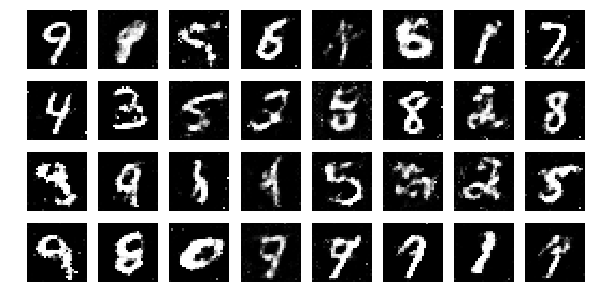

In [0]:
%matplotlib inline
num_test = 32
test = vectors_to_images(generator(noise(num_test))).cpu().data.numpy()
fig = plt.figure(figsize = (10,5))
for i in range(num_test):
    fig.add_subplot(4,8,i+1)
    plt.axis('off')
    plt.imshow(test[i][0], cmap='gray', interpolation='nearest')